In [2]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS
STOPWORDS=STOPWORDS-set({"A","C","G","T"})
import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = (15,10)
import scipy.stats as stats
import seaborn as sns
import os
from tqdm import tqdm
plt.rcParams["figure.figsize"] = (20,12)


In [3]:
vcf="/storage/czhang/projects/STR_expression/data/STRRelevant/Filter_Merged_STRs_All_Samples_New.no_header.vcf"
strf="/storage/czhang/projects/STR_expression/data/hg38.hipstr_reference_withmotif_stranded.bed"
df=pd.read_csv(vcf,sep='\t',header=None)
str_df=pd.read_csv(strf,sep='\t',header=None)
str_df.columns=["chr","start","end","meh","+","-"]
global str_df_dict
str_df_dict={}
for i in range(1,23):
    cur_chr="chr"+str(i)
    str_df_dict[i]=str_df[str_df["chr"]==cur_chr].sort_values(by=["start"]).reset_index(drop=True).drop(['meh'],axis=1)

/storage/czhang/apps/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (0,9,17,22,27,32,35,40,57,58,60,63,65,66,75,77,82,86,94,96,97,99,105,112,114,117,126,133,134,136,139,140,141,146,149,150,163,164,166,171,172,175,178,180,192,199,212,213,223,225,229,230,231,234,243,244,246,247,248,249,250,251,253,254,256,259,260,261,263,265,272,274,278,279,285,288,293,294,301,305,306,307,310,312,313,314,315,316,322,323,326,329,330,333,334,336,339,346,351,352,357,362,363,365,369,370,372,377,383,384,386,389,390,392,400,407,408,411,413,414,415,416,419,421,424,426,433,436,450,454,459,460,464,469,470,475,476,479,484,491,494,496,498,499,501,504,511,514,516,519,526,529,530,537,541,542,543,549,551,556,557,559,560,566,568,570,572,575,576,581,582,584,586,593,599,602,604,605,611,613,616,621,626,629,631,635,637,638,642,643,645,648,653,658) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body

## Redo the enrichment analysis for all tissues with strand info (do not avg OR)

In [28]:
def check_in_range(pos,df,strand):
    idx=df["start"].searchsorted(pos)
    start,end=df.loc[idx,"start"],df.loc[idx,"end"]
    if pos in range(start,end+1):
        # consider strand
        return df.loc[idx,strand]
    else:
        return "N/A"
def check_spliceSTR(row,spliceSTRs):
    if row['str.id'] in spliceSTRs:
        return "True"
    else:
        return "False"
def fun(row):
    strand=row['strand']
    if strand=='Not Found':
        return "N/A"
    pos=row['BP']
    cur_chr=row['CHR']
    df=str_df_dict[cur_chr]
#     print(row)
    return check_in_range(pos,df,strand)
def count_df(df):
#     df['spliceSTR']=df.apply(check_spliceSTR,spliceSTRs=spliceSTRs,axis=1)
    df['repeat_unit']=df.apply(fun,axis=1)
    str_cleaned_df=df[df['repeat_unit']!='N/A']
    counts=str_cleaned_df.groupby(['repeat_unit']).count()['CHR']
    counts_srted=counts.sort_values(ascending=False)
    return counts_srted,str_cleaned_df
# add strand information to the dataframes
def add_strand(row):
    global gene_anno_dict
    cur_id=row['gene'].split('.')[0]
    if(cur_id in gene_anno_dict):
        cur_res=gene_anno_dict[cur_id]
    else:
        cur_res="Not Found"
    row['strand']=cur_res
    return row
def fisher_exact_motif_test(df):
    pvals=[]
    motifs=[]
    odds=[]
    spliceSTR_and_motif=[]
    not_spliceSTR_and_motif=[]
    spliceSTR_and_not_motif=[]
    not_spliceSTR_and_not_motif=[]
    motifs_to_test=df['repeat_unit'].unique()
    for cur_motif in motifs_to_test:
        cur_cleaned=df[df['repeat_unit']==cur_motif]
        cur_sig_df=cur_cleaned[cur_cleaned['spliceSTR']=="True"]
        A=len(cur_sig_df)
        cur_nonsig_df=cur_cleaned[cur_cleaned['spliceSTR']!="True"]
        C=len(cur_nonsig_df)
        cur_cleaned_non_motif=df[df['repeat_unit']!=cur_motif]
        cur_cleaned_non_motif_sig=cur_cleaned_non_motif[cur_cleaned_non_motif['spliceSTR']=="True"]
        cur_cleaned_non_motif_nonsig=cur_cleaned_non_motif[cur_cleaned_non_motif['spliceSTR']!="True"]
        B=len(cur_cleaned_non_motif_sig)
        D=len(cur_cleaned_non_motif_nonsig)
        
        fisher_mtx=[
            [A,B],
            [C,D]
        ]
        spliceSTR_and_motif.append(A)
        spliceSTR_and_not_motif.append(B)
        not_spliceSTR_and_motif.append(C)
        not_spliceSTR_and_not_motif.append(D)
        oddsratio, pvalue = stats.fisher_exact(fisher_mtx)
        odds.append(oddsratio)
        pvals.append(pvalue)
        motifs.append(cur_motif)
    result_df=pd.DataFrame([motifs,pvals,odds,spliceSTR_and_motif,spliceSTR_and_not_motif,\
                            not_spliceSTR_and_motif,not_spliceSTR_and_not_motif]).T
    result_df.columns=['motif','pval','OR',"spliceSTR_and_motif","spliceSTR_and_not_motif",\
                       "not_spliceSTR_and_motif","not_spliceSTR_and_not_motif"]
    result_df=result_df.sort_values(by=['pval'],ascending=True)
    return result_df
def reverse_complement(string):
    string=string[::-1]
    trans={
        'A':'T',
        'T':'A',
        'C':'G',
        'G':'C'
    }
    rc=''.join([trans[x] for x in string])
    return rc
def replace_STR_id(row):
    cur_id=row['str.id']
    a,b=cur_id.split('_')
    if(a=='STR'):
        cur_chr=str(row['CHR'])
        row['str.id']='_'.join([cur_chr,b])
    return row
        

In [5]:
for a,b,c in os.walk("/storage/czhang/projects/STR_expression/data/alltis_cleaned"):
    all_tissues=c
all_tissues=[c.split('.')[0] for c in all_tissues]
all_tissues

['Brain-Substantianigra',
 'Spleen',
 'Brain-Cortex',
 'Adipose-Visceral_Omentum',
 'Brain-Hippocampus',
 'Thyroid',
 'Kidney-Cortex',
 'Artery-Coronary',
 'Prostate',
 'Artery-Tibial',
 'Esophagus-Muscularis',
 'Testis',
 'Ovary',
 'Vagina',
 'Esophagus-Mucosa',
 'Brain-FrontalCortex_BA9',
 'SmallIntestine-TerminalIleum',
 'Brain-Spinalcord_cervicalc-1',
 'Artery-Aorta',
 'Stomach',
 'Breast-MammaryTissue',
 'Brain-Nucleusaccumbens_basalganglia',
 'Muscle-Skeletal',
 'Skin-NotSunExposed_Suprapubic',
 'Heart-AtrialAppendage',
 'Brain-Cerebellum',
 'Skin-SunExposed_Lowerleg',
 'Heart-LeftVentricle',
 'Nerve-Tibial',
 'Pancreas',
 'Colon-Sigmoid',
 'Brain-Putamen_basalganglia',
 'Adipose-Subcutaneous',
 'Colon-Transverse',
 'Brain-Caudate_basalganglia',
 'MinorSalivaryGland',
 'Brain-CerebellarHemisphere',
 'Liver',
 'AdrenalGland',
 'Brain-Hypothalamus',
 'Bladder',
 'Cells-Culturedfibroblasts',
 'Cells-EBV-transformedlymphocytes',
 'Brain-Anteriorcingulatecortex_BA24',
 'Uterus',
 'Pit

In [6]:
# load gtf files
gene_anno=pd.read_csv("/storage/czhang/projects/STR_expression/data/hg38.ensGene.gtf",sep='\t',header=None)
gene_anno[9]=gene_anno[8].apply(lambda x: x.split(';')[0].split('"')[1])
global gene_anno_dict
gene_anno_dict=dict(zip(gene_anno[9],gene_anno[6]))

In [39]:
all_dfs=[]
root="/storage/czhang/projects/STR_expression/data/allTis"

all_dir="/storage/czhang/projects/STR_expression/data/alltis_cleaned"
result_dict={}
for i in tqdm(all_tissues):
    cur_splicestr_f=root+'/'+i+'/'+"fdrRes_New.csv"
    cur_non_splicestr_f=all_dir+'/'+i+'.'+"all.tsv"
    if((os.path.isfile(cur_splicestr_f) == False) or (os.path.isfile(cur_non_splicestr_f) ==False)):
#         print(os.path.isfile(cur_splicestr_f))
#         print(cur_splicestr_f)
        print("Skipped {}".format(i))
        continue
    df1=pd.read_csv(cur_splicestr_f)
    df1=df1.drop(['Unnamed: 0'],axis=1)
    columns_to_keep=['chrom','gene','str.id','slope','error','pVal','str.start','spliceSTR']
    df1['spliceSTR']="True"
    df1=df1[columns_to_keep]
    df2=pd.read_csv(cur_non_splicestr_f,sep='\t')
    df2=df2[columns_to_keep]
    df1.columns=['CHR', 'gene', 'str.id', 'slope', 'error', 'P', 'BP', 'spliceSTR']
    df2.columns=['CHR', 'gene', 'str.id', 'slope', 'error', 'P', 'BP', 'spliceSTR']
    cur_df=pd.concat([df1,df2]).reset_index(drop=True)
    cur_df=cur_df.apply(replace_STR_id,axis=1)
    all_dfs.append(cur_df)

100%|██████████| 50/50 [48:14<00:00, 57.89s/it]


In [40]:
all_df=pd.concat(all_dfs).reset_index(drop=True)

In [ ]:
all_df=all_df.apply(add_strand, axis=1)

In [ ]:
all_counts, all_cleaned=count_df(all_df)


In [90]:
all_cleaned['exon_str.id']=all_cleaned['gene']+'->'+all_cleaned['str.id']
all_cleaned=all_cleaned.drop_duplicates(subset=['exon_str.id','spliceSTR'])
unique_exon_strs=all_cleaned['exon_str.id'].unique()


<ipython-input-90-0b5c125b1396>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_cleaned['exon_str.id']=all_cleaned['gene']+'->'+all_cleaned['str.id']


In [91]:
all_cleaned

,CHR,gene,str.id,slope,error,P,BP,spliceSTR,strand,repeat_unit,exon_str.id
0,1,ENSG00000188290.10_1,1_995509,-0.504323,0.079294,1.880711e-08,995509,True,-,A,ENSG00000188290.10_1->1_995509
1,1,ENSG00000117632.22_5,1_25910542,0.389895,0.090739,5.565419e-05,25910542,True,-,AAAAAT,ENSG00000117632.22_5->1_25910542
2,1,ENSG00000084636.17_60,1_31653747,-0.597617,0.083737,7.511659e-10,31653747,True,-,GT,ENSG00000084636.17_60->1_31653747
3,1,ENSG00000049089.13_4,1_40313125,0.464201,0.095235,7.925746e-06,40313125,True,-,AAAAG,ENSG00000049089.13_4->1_40313125
4,1,ENSG00000117395.12_9,1_43175493,-0.715598,0.084379,3.657251e-12,43175493,True,-,AAAAT,ENSG00000117395.12_9->1_43175493
...,...,...,...,...,...,...,...,...,...,...,...
300,19,ENSG00000105619.13_2,19_54115894,0.441259,0.087689,3.228689e-06,54115894,True,-,AAAC,ENSG00000105619.13_2->19_54115894
310,20,ENSG00000130703.15_17,20_62293036,0.430028,0.079277,7.855834e-07,62293036,True,+,T,ENSG00000130703.15_17->20_62293036
314,21,ENSG00000185917.13_3,21_36067654,0.529087,0.084667,2.285920e-08,36067654,True,-,T,ENSG00000185917.13_3->21_36067654
43210,3,ENSG00000251011.5_3,3_133241610,-2.071318,inf,NaN,133241610,False,-,A,ENSG00000251011.5_3->3_133241610


In [103]:
res=[]
for cur_exon_str in tqdm(unique_exon_strs):

    cur_df=all_cleaned[all_cleaned['exon_str.id']==cur_exon_str]
    sample_row=cur_df.iloc[0,]
    if np.any(cur_df['spliceSTR'].values):
        cur_res=[sample_row['exon_str.id'],sample_row['repeat_unit'],"True"]
    else:
        cur_res=[sample_row['exon_str.id'],sample_row['repeat_unit'],"False"]
    res.append(cur_res)
res

100%|██████████| 510333/510333 [7:19:14<00:00, 19.36it/s]  


[['ENSG00000188290.10_1->1_995509', 'A', 'True'],
 ['ENSG00000117632.22_5->1_25910542', 'AAAAAT', 'True'],
 ['ENSG00000084636.17_60->1_31653747', 'GT', 'True'],
 ['ENSG00000049089.13_4->1_40313125', 'AAAAG', 'True'],
 ['ENSG00000117395.12_9->1_43175493', 'AAAAT', 'True'],
 ['ENSG00000132781.17_16->1_45338731', 'A', 'True'],
 ['ENSG00000132780.16_3->1_45587186', 'T', 'True'],
 ['ENSG00000116641.17_54->1_62475498', 'T', 'True'],
 ['ENSG00000117054.13_2->1_75737795', 'T', 'True'],
 ['ENSG00000117054.13_6->1_75732150', 'A', 'True'],
 ['ENSG00000183291.15_1->1_86922420', 'AC', 'True'],
 ['ENSG00000117226.11_9->1_89001471', 'A', 'True'],
 ['ENSG00000118292.8_7->1_150284870', 'GTT', 'True'],
 ['ENSG00000182134.15_17->1_151770079', 'CCCTCT', 'True'],
 ['ENSG00000143156.13_2->1_169319019', 'AAAATT', 'True'],
 ['ENSG00000143207.19_7->1_176160256', 'A', 'True'],
 ['ENSG00000117266.15_11->1_205520700', 'A', 'True'],
 ['ENSG00000117691.9_3->1_212449887', 'AAAC', 'True'],
 ['ENSG00000196187.11_10->1

In [106]:
res_df=pd.DataFrame(res)
res_df.columns=['exon_str.id','repeat_unit','spliceSTR']
# res_df['spliceSTR']=res_df.apply(lambda row: "True" if row['spliceSTR']==True else "False",axis=1)

In [107]:
res_df

,exon_str.id,repeat_unit,spliceSTR
0,ENSG00000188290.10_1->1_995509,A,True
1,ENSG00000117632.22_5->1_25910542,AAAAAT,True
2,ENSG00000084636.17_60->1_31653747,GT,True
3,ENSG00000049089.13_4->1_40313125,AAAAG,True
4,ENSG00000117395.12_9->1_43175493,AAAAT,True
...,...,...,...
510328,ENSG00000224397.5_2->20_50284648,AATG,False
510329,ENSG00000101187.15_12->20_62678533,T,False
510330,ENSG00000101187.15_12->20_62680570,T,False
510331,ENSG00000251011.5_3->3_133241610,A,False


In [111]:
all_res=fisher_exact_motif_test(res_df)
all_res['-log(OR)']=all_res['OR'].apply(lambda x: np.log2(x))

In [112]:
all_res=all_res[(all_res['pval']<0.05) & (all_res['spliceSTR_and_motif']>10)]

In [113]:
all_res.head(15)

,motif,pval,OR,spliceSTR_and_motif,spliceSTR_and_not_motif,not_spliceSTR_and_motif,not_spliceSTR_and_not_motif,-log(OR)
2,GT,8.12469e-138,2.18657,1438,20798,14961,473136,1.128667
5,T,4.52013e-96,0.747946,8529,13707,221658,266439,-0.418995
0,A,5.96747e-67,0.777103,6921,15315,179474,308623,-0.363822
6,AC,3.20401e-58,1.85864,890,21346,10709,477388,0.894250
18,ATTT,2.05901e-39,2.14945,401,21835,4135,483962,1.103966
14,GTTTT,1.12988e-26,2.24381,240,21996,2362,485735,1.165954
21,AAAT,3.2918e-23,1.99971,271,21965,2993,485104,0.999788
16,GTTT,7.28969e-21,2.04852,228,22008,2456,485641,1.034585
10,AAAC,2.82193e-12,1.98699,136,22100,1507,486590,0.990588
28,AAT,3.06233e-12,2.04409,126,22110,1357,486740,1.031455


In [288]:
# draw paired plots 
pairs_present=[]
added=[]
top_motifs=all_res['motif'].values
no_rc=[]
counter=0
for i in top_motifs:
    i_rc=reverse_complement(i)
    if(i_rc not in top_motifs):
        counter+=1
        no_rc.append(i)
        continue
    if i in top_motifs:
        if((i not in added) and (i_rc not in added)):
            pairs_present.append(sorted([i,i_rc]))
            added.append(i)
            added.append(i_rc)
print(counter)

13


In [289]:
group_ls=['A/C' for i in range(len(pairs_present))]
group_ls_2=['T/G' for i in range(len(pairs_present))]
group_ls.extend(group_ls_2)


In [290]:
def fun(s):
    rc=reverse_complement(s)
    sorted_str=sorted([s,rc])
    return ":".join(sorted_str) 
motifs=[x[0] for x in pairs_present]
motifs_2=[x[1] for x in pairs_present]
motifs.extend(motifs_2)
motifs_original=[x for x in motifs]
motifs=[fun(x) for x in motifs]


In [291]:
logORs=[]
for motif in motifs_original:
    row=all_res[all_res['motif']==motif]
    cur_val=row['-log(OR)'].values[0]
    logORs.append(row['-log(OR)'].values[0])


In [292]:
original_length=len(no_rc)
no_rc_final=[x for x in no_rc]
no_rc_final.extend([x for x in no_rc])


In [293]:
nc_motifs=[check_strand(i) for i in (no_rc)]
nc_motifs2=['A/C' if x=='T/G' else 'T/G' for x in nc_motifs]
nc_motifs.extend(nc_motifs2)

In [294]:
def check_strand(string):
    ac_count=string.count('A')
    ac_count+=string.count('C')
    tg_count=string.count('T')
    tg_count+=string.count('G')
    if(ac_count>tg_count):
        return 'A/C'
    else:
        return 'T/G'

In [295]:
nc_or=[]
counter=0
for motif in no_rc_final:
    row=all_res[all_res['motif']==motif]
    counter+=1
    if(counter>original_length):
        nc_or.append(0.0)
        continue
    cur_val=row['-log(OR)'].values[0]
    nc_or.append(row['-log(OR)'].values[0])
nc_df=pd.DataFrame(np.array([no_rc_final,nc_motifs,nc_or]).T,columns=['group','motif','-logOR'])

In [296]:
df2=pd.concat([df,nc_df])

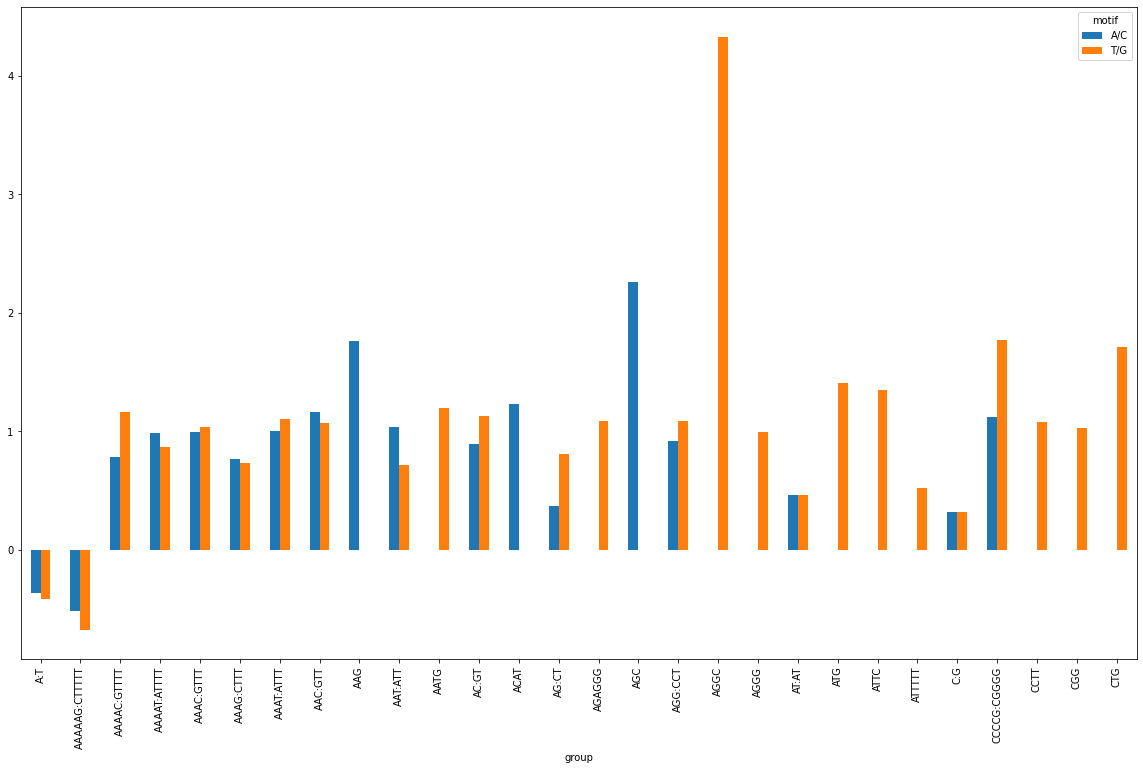

In [297]:
df2.pivot('group','motif','-logOR').astype(float).plot(kind='bar')